In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

In [35]:
raw_documents = []
snippets = []
with open("data.txt", "r", encoding='utf-8') as f:
    for line in f.readlines():
        text = line.strip()
        raw_documents.append( text.lower() )
        
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 4551 raw text documents


In [36]:
# custom stopwords
custom_stop_words = []
with open("stopwords.txt", "r", encoding='utf-8') as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [37]:
# create BoW + tf-idf model
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms = vectorizer.get_feature_names()
joblib.dump((A,terms,snippets), "articles-tfidf.pkl")

Created 4551 X 10285 TF-IDF-normalized document-term matrix


['articles-tfidf.pkl']

In [38]:
# top features from tf-idf model
import operator


sums = np.array(A.sum(axis=0)).ravel()
# map weights to the terms
weights = { term: sums[col] for col, term in enumerate(terms)}
ranking = sorted(weights.items(), key=operator.itemgetter(1), reverse=True)
for i, pair in enumerate( ranking[0:20] ):
    print( "%s (%.2f)" % ( pair[0], pair[1] ) )

trump (190.87)
people (109.90)
eu (109.17)
film (91.35)
uk (89.10)
bank (78.69)
time (76.12)
brexit (67.98)
health (61.59)
government (60.24)
back (60.24)
clinton (59.95)
get (57.37)
world (56.85)
campaign (56.35)
women (55.82)
way (54.95)
before (54.60)
vote (54.33)
work (54.04)


In [39]:
#Apply NMF

from sklearn.decomposition import NMF

(A,terms,snippets) = joblib.load( "articles-tfidf.pkl")

# create the model
k = 10
model = NMF( init="nndsvd", n_components=k ) 

W = model.fit_transform( A )
H = model.components_

In [40]:
W.shape
W[0,:].round(2)
H.shape
H[:,terms.index('brexit')].round(2)

array([ 0.99,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  0.  ,  0.  ,  0.25,  0.  ])

In [41]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: eu, uk, brexit, britain, european, leave, europe, vote, referendum, trade, british, government, minister, market, union, cameron, deal, economic, economy, remain
Topic 02: trump, clinton, donald, republican, campaign, president, hillary, cruz, sanders, presidential, obama, election, nominee, candidate, state, america, party, rubio, democratic, american
Topic 03: film, films, movie, star, director, hollywood, actor, story, drama, cinema, festival, life, character, best, black, movies, oscar, screen, comedy, man
Topic 04: league, season, leicester, goal, premier, united, city, liverpool, game, ball, team, players, arsenal, manchester, chelsea, football, club, palace, half, manager
Topic 05: bank, banks, banking, financial, rbs, customers, shares, deutsche, barclays, lloyds, hsbc, investors, market, rates, interest, rate, markets, business, chief, capital
Topic 06: health, nhs, care, patients, mental, doctors, hospital, people, services, junior, social, patient, healthcare, hunt

In [42]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Brexit X-men: how the prime minister’s key negotiators are coping When Boris Johnson was working for
02. Archbishop accuses Farage of racism and 'accentuating fear for political gain' – EU referendum live 
03. Brexit could shift Europe's political centre of gravity, says Fitch A vote for Brexit in next month’
04. EU leaders line up to insist UK will pay a high price for Brexit stance Britain and the EU appear mo
05. Would Brexit make UK businesses less competitive? In this week’s EU referendum Q&A our panel discuss
06. David Cameron: being in the EU gives Britain key counter-terrorism information David Cameron has sai
07. Slovakian foreign minister: I will support any measure to stop Brexit The new Slovakian EU presidenc
08. Brexit weekly briefing: we're going to be kept in the dark Welcome to the weekly Brexit briefing, a 
09. What would Brexit mean for housing, regeneration and central government? Housing and regeneration: T
10. Cameron names referendum date as Gove declares for 

In [43]:
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k)

['articles-model-nmf-k10.pkl']

In [11]:
#Topic coherence

kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████████████████████████████████████| 12/12 [01:01<00:00,  5.16s/it]


In [44]:
import re
import gensim


class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            

docgen = TokenGenerator( raw_documents, custom_stop_words )
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)
print( "Model has %d terms" % len(w2v_model.wv.vocab) )
w2v_model.save("w2v-model.bin")

Model has 12192 terms


In [46]:
#TC-W2C

from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.3395
K=05: Coherence=0.3591
K=06: Coherence=0.3676
K=07: Coherence=0.3845
K=08: Coherence=0.3977
K=09: Coherence=0.4007
K=10: Coherence=0.4049
K=11: Coherence=0.4045
K=12: Coherence=0.4080
K=13: Coherence=0.4086
K=14: Coherence=0.4055
K=15: Coherence=0.4091


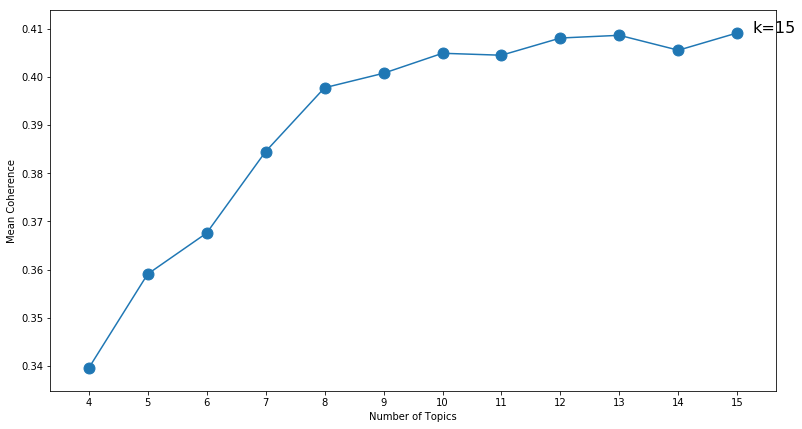

In [47]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [48]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: eu, uk, britain, brexit, european, leave, europe, referendum, british, vote, trade, cameron, minister, union, government, deal, remain, prime, negotiations, brussels
Topic 02: trump, donald, president, republican, campaign, america, obama, white, presidential, american, election, people, nominee, candidate, elect, political, country, americans, house, pence
Topic 03: film, films, movie, star, director, hollywood, actor, story, drama, cinema, festival, life, character, best, black, movies, oscar, screen, comedy, man
Topic 04: ball, goal, liverpool, game, half, palace, united, corner, shot, back, everton, west, swansea, minutes, sunderland, team, arsenal, left, chelsea, kick
Topic 05: bank, banks, banking, rbs, deutsche, customers, barclays, financial, shares, hsbc, lloyds, capital, investors, executive, crisis, chief, pay, accounts, branches, mortgage
Topic 06: nhs, doctors, patients, care, junior, hospital, health, hunt, patient, staff, medical, bma, doctor, healthcare, hospi

In [49]:
#UCI
from math import log
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            texts_2w = 0
            texts_1stw = 0
            texts_2ndw = 0
            #pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            for topic_ind2 in range(len(term_rankings)):
                if pair[0] in term_rankings[topic_ind2] and pair[1] in term_rankings[topic_ind2]:
                    texts_2w += 1
                if pair[0] in term_rankings[topic_ind2]:
                    texts_1stw += 1
                if pair[1] in term_rankings[topic_ind2]:
                    texts_2ndw += 1
            pair_prob = log((10**-12 + texts_2w / len(term_rankings)) / ((texts_1stw / len(term_rankings))*texts_1stw / len(term_rankings)))
            pair_scores.append(pair_prob)
        # get the sum for all pairs in this topic
        topic_score = sum(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    #print(term_rankings)
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=258.5439
K=05: Coherence=288.6032
K=06: Coherence=315.0272
K=07: Coherence=342.5912
K=08: Coherence=374.8193
K=09: Coherence=377.2525
K=10: Coherence=401.0942
K=11: Coherence=407.7090
K=12: Coherence=423.8901
K=13: Coherence=437.3284
K=14: Coherence=443.4574
K=15: Coherence=443.4577


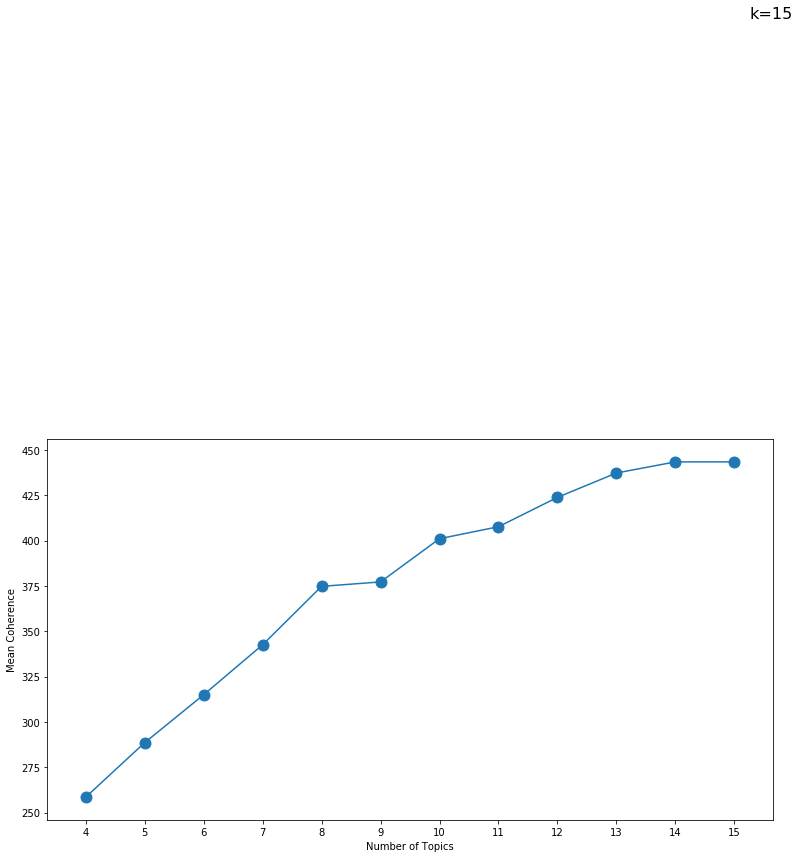

In [50]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [51]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: eu, uk, britain, brexit, european, leave, europe, referendum, british, vote, trade, cameron, minister, union, government, deal, remain, prime, negotiations, brussels
Topic 02: trump, donald, president, republican, campaign, america, obama, white, presidential, american, election, people, nominee, candidate, elect, political, country, americans, house, pence
Topic 03: film, films, movie, star, director, hollywood, actor, story, drama, cinema, festival, life, character, best, black, movies, oscar, screen, comedy, man
Topic 04: ball, goal, liverpool, game, half, palace, united, corner, shot, back, everton, west, swansea, minutes, sunderland, team, arsenal, left, chelsea, kick
Topic 05: bank, banks, banking, rbs, deutsche, customers, barclays, financial, shares, hsbc, lloyds, capital, investors, executive, crisis, chief, pay, accounts, branches, mortgage
Topic 06: nhs, doctors, patients, care, junior, hospital, health, hunt, patient, staff, medical, bma, doctor, healthcare, hospi

In [52]:
#Umass

from math import log
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            texts_2w = 0 #two words probability
            texts_1stw = 0 #probability of firts word in pair
            #pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            for topic_ind2 in range(len(term_rankings)):
                if pair[0] in term_rankings[topic_ind2] and pair[1] in term_rankings[topic_ind2]:
                    texts_2w += 1
                if pair[0] in term_rankings[topic_ind2]:
                    texts_1stw += 1
            pair_prob = log((10**-12 + texts_2w / len(term_rankings)) / (texts_1stw / len(term_rankings)))
            pair_scores.append(pair_prob)
        # get the sum for all pairs in this topic
        topic_score = sum(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    #print(term_rankings)
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=-2.4260
K=05: Coherence=-8.4564
K=06: Coherence=-12.4725
K=07: Coherence=-13.2688
K=08: Coherence=-9.9640
K=09: Coherence=-18.1847
K=10: Coherence=-16.4656
K=11: Coherence=-21.4167
K=12: Coherence=-21.4564
K=13: Coherence=-22.2797
K=14: Coherence=-25.8373
K=15: Coherence=-31.9542


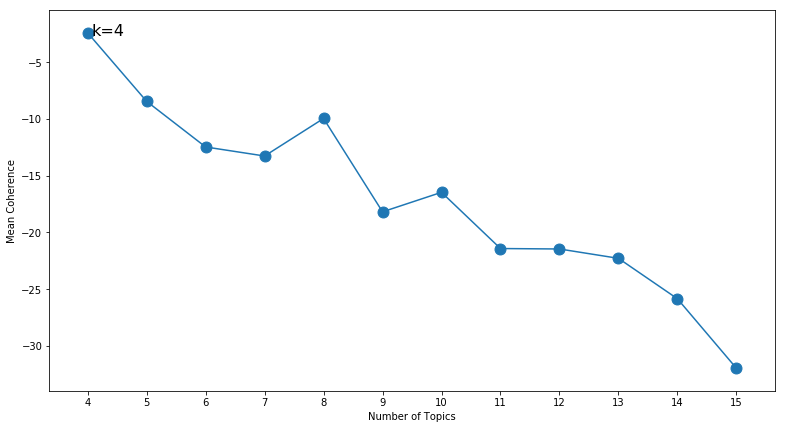

In [53]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [54]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: eu, brexit, uk, britain, bank, referendum, vote, leave, european, government, cameron, labour, minister, europe, banks, british, market, remain, prime, trade
Topic 02: trump, clinton, republican, donald, campaign, president, hillary, cruz, sanders, election, presidential, obama, party, candidate, nominee, state, america, women, rubio, voters
Topic 03: film, people, music, health, album, life, time, women, care, get, nhs, work, world, really, mental, band, love, song, way, pop
Topic 04: league, season, leicester, premier, goal, united, city, liverpool, game, ball, team, players, arsenal, manchester, chelsea, football, club, palace, half, manager


In [55]:
#Aplly LSA

from sklearn.decomposition import TruncatedSVD
k = 10
model = TruncatedSVD(n_components=k ) 

W = model.fit_transform( A )
H = model.components_

In [56]:
W.shape
W[0,:].round(2)
H.shape
H[:,terms.index('brexit')].round(2)

array([ 0.09, -0.1 ,  0.19,  0.1 , -0.09, -0.04,  0.01, -0.02, -0.08, -0.03])

In [59]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, clinton, uk, brexit, campaign, time, vote, film, bank, party, government, britain, donald, back, women, get, leave, think
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign, obama, nominee, election, candidate, rubio, america, senator, democratic, state, republicans
Topic 03: eu, brexit, uk, britain, vote, referendum, leave, european, bank, cameron, government, minister, labour, europe, trade, prime, campaign, remain, party, market
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city, players, arsenal, game, brexit, chelsea, team, manchester, palace, football, trump
Topic 05: bank, banks, banking, financial, customers, rbs, shares, deutsche, barclays, lloyds, hsbc, investors, rates, chief, health, rate, executive, pay, interest, royal
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services, junior, patient, healthcare, hunt, medical, chil

In [60]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Obama talks trans bathroom access as Trump defends business practices – as it happened Here are the 
02. Melania Trump defends husband's 'boy talk' in CNN interview – as it happened Speaking to CNN’s Ander
03. Hillary Clinton: 'I'm sick of the Sanders campaign's lies' – as it happened One of the most importan
04. Donald Trump hits delegate count needed for Republican nomination – as it happened On the one hand, 
05. Clinton seizes on Trump tweets for day of campaigning in Florida – as it happened Donald Trump was a
06. Trump wins Washington primary as protests erupt by Albuquerque rally – as it happened Donald Trump w
07. DNC 2016, day three: emotional Obama passes baton to Clinton – as it happened The sun has set on day
08. Trump campaign reportedly vetting Christie, Gingrich as potential running mates – as it happened Don
09. Donald Trump: money raised by Hillary Clinton is 'blood money' – as it happened Hillary Clinton deli
10. Donald Trump: Hillary Clinton has 'no right to be r

In [61]:
#Topic coherence

kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = TruncatedSVD(n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████████████████████████████████████| 12/12 [00:11<00:00,  1.01it/s]


In [62]:
import gensim

w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 12192 terms


In [64]:
#TC-W2C

from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.3345
K=05: Coherence=0.3494
K=06: Coherence=0.3640
K=07: Coherence=0.3867
K=08: Coherence=0.3881
K=09: Coherence=0.3852
K=10: Coherence=0.3792
K=11: Coherence=0.3693
K=12: Coherence=0.3606
K=13: Coherence=0.3555
K=14: Coherence=0.3502
K=15: Coherence=0.3452


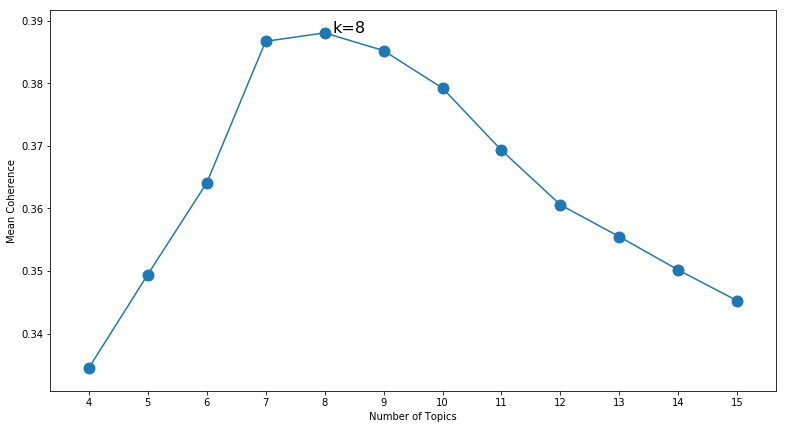

In [65]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [66]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, clinton, uk, brexit, campaign, time, vote, film, bank, party, government, britain, donald, back, women, get, leave, think
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign, obama, nominee, election, candidate, rubio, america, senator, democratic, state, republicans
Topic 03: eu, brexit, uk, britain, vote, referendum, leave, european, bank, cameron, government, minister, labour, europe, trade, prime, campaign, remain, party, market
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city, players, arsenal, game, brexit, chelsea, team, manchester, palace, football, trump
Topic 05: bank, banks, banking, financial, customers, rbs, shares, deutsche, barclays, lloyds, hsbc, investors, rates, chief, health, rate, executive, pay, interest, royal
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services, junior, patient, healthcare, hunt, medical, chil

In [68]:
#UCI
from math import log
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            texts_2w = 0
            texts_1stw = 0
            texts_2ndw = 0
            #pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            for topic_ind2 in range(len(term_rankings)):
                if pair[0] in term_rankings[topic_ind2] and pair[1] in term_rankings[topic_ind2]:
                    texts_2w += 1
                if pair[0] in term_rankings[topic_ind2]:
                    texts_1stw += 1
                if pair[1] in term_rankings[topic_ind2]:
                    texts_2ndw += 1
            pair_prob = log((10**-12 + texts_2w / len(term_rankings)) / ((texts_1stw / len(term_rankings))*texts_1stw / len(term_rankings)))
            pair_scores.append(pair_prob)
        # get the sum for all pairs in this topic
        topic_score = sum(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    #print(term_rankings)
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=128.7654
K=05: Coherence=186.4956
K=06: Coherence=228.5430
K=07: Coherence=269.8552
K=08: Coherence=299.9735
K=09: Coherence=295.3372
K=10: Coherence=299.5994
K=11: Coherence=280.3750
K=12: Coherence=264.8417
K=13: Coherence=252.9619
K=14: Coherence=236.4122
K=15: Coherence=228.5630


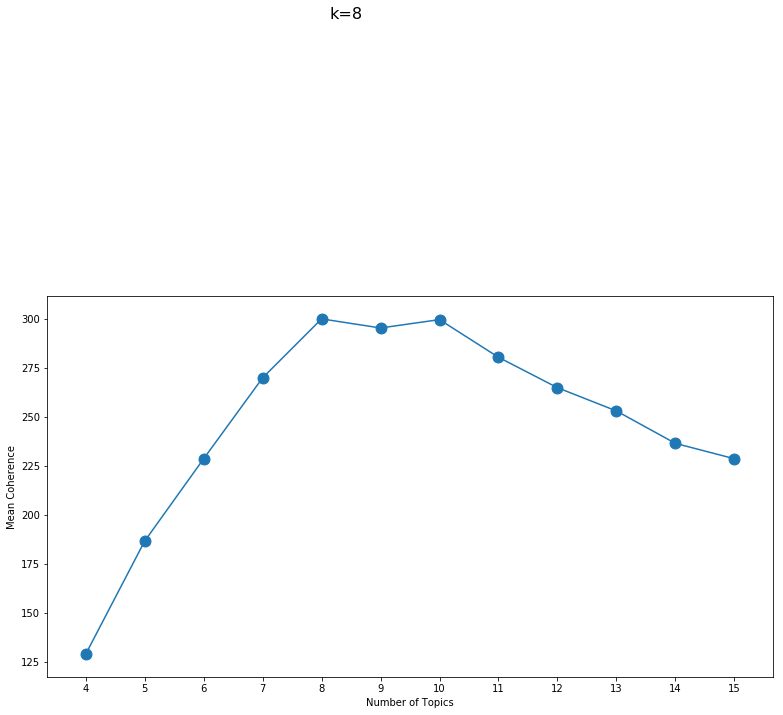

In [69]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [70]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, clinton, uk, brexit, campaign, time, vote, film, bank, party, government, britain, donald, back, women, get, leave, think
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign, obama, nominee, election, candidate, rubio, america, senator, democratic, state, republicans
Topic 03: eu, brexit, uk, britain, vote, referendum, leave, european, bank, cameron, government, minister, labour, europe, trade, prime, campaign, remain, party, market
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city, players, arsenal, game, brexit, chelsea, team, manchester, palace, football, trump
Topic 05: bank, banks, banking, financial, customers, rbs, shares, deutsche, barclays, lloyds, hsbc, investors, rates, chief, health, rate, executive, pay, interest, royal
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services, junior, patient, healthcare, hunt, medical, chil

In [71]:
#Umass

from math import log
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            texts_2w = 0 #two words probability
            texts_1stw = 0 #probability of firts word in pair
            #pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            for topic_ind2 in range(len(term_rankings)):
                if pair[0] in term_rankings[topic_ind2] and pair[1] in term_rankings[topic_ind2]:
                    texts_2w += 1
                if pair[0] in term_rankings[topic_ind2]:
                    texts_1stw += 1
            pair_prob = log((10**-12 + texts_2w / len(term_rankings)) / (texts_1stw / len(term_rankings)))
            pair_scores.append(pair_prob)
        # get the sum for all pairs in this topic
        topic_score = sum(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    #print(term_rankings)
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=-57.8924
K=05: Coherence=-52.1105
K=06: Coherence=-49.6637
K=07: Coherence=-44.5493
K=08: Coherence=-42.6755
K=09: Coherence=-54.2990
K=10: Coherence=-62.2472
K=11: Coherence=-79.4029
K=12: Coherence=-94.2496
K=13: Coherence=-105.9831
K=14: Coherence=-117.7408
K=15: Coherence=-127.8348


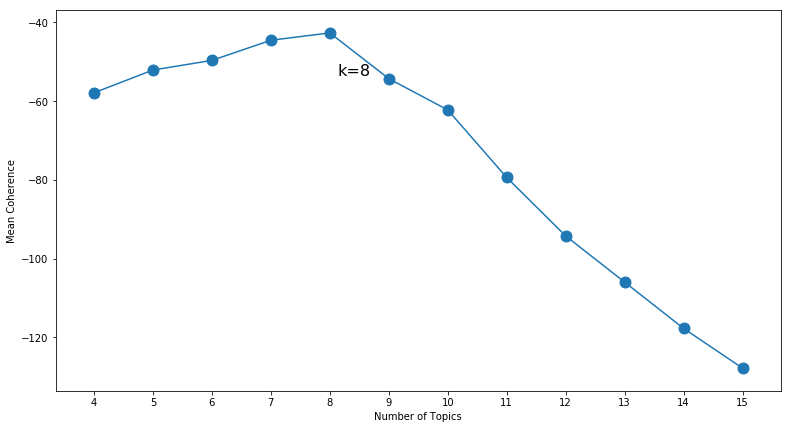

In [72]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [73]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: trump, eu, people, clinton, uk, brexit, campaign, time, vote, film, bank, party, government, britain, donald, back, women, get, leave, think
Topic 02: trump, clinton, republican, donald, hillary, cruz, president, sanders, presidential, campaign, obama, nominee, election, candidate, rubio, america, senator, democratic, state, republicans
Topic 03: eu, brexit, uk, britain, vote, referendum, leave, european, bank, cameron, government, minister, labour, europe, trade, prime, campaign, remain, party, market
Topic 04: league, eu, season, leicester, premier, goal, united, liverpool, ball, city, players, arsenal, game, brexit, chelsea, team, manchester, palace, football, trump
Topic 05: bank, banks, banking, financial, customers, rbs, shares, deutsche, barclays, lloyds, hsbc, investors, rates, chief, health, rate, executive, pay, interest, royal
Topic 06: health, nhs, care, mental, patients, doctors, hospital, people, social, services, junior, patient, healthcare, hunt, medical, chil

In [74]:
#Apply LDA

from sklearn.decomposition import LatentDirichletAllocation

# create the model
k = 10
model = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)

W = model.fit_transform( A )
H = model.components_

In [75]:
W.shape
W[0,:].round(2)
H.shape
H[:,terms.index('brexit')].round(2)

array([  0.1 ,  67.76,   0.1 ,   0.1 ,   0.41,   0.1 ,   0.1 ,   0.1 ,
         0.1 ,   0.1 ])

In [76]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: league, season, leicester, premier, goal, liverpool, ball, game, united, players, team, city, arsenal, football, chelsea, club, manchester, half, manager, everton
Topic 02: trump, eu, bank, uk, people, brexit, clinton, government, vote, campaign, britain, health, party, referendum, leave, banks, nhs, european, financial, donald
Topic 03: promoter, prize, entries, tickets, barclays, winners, competition, details, n1, entry, teamed, reserves, kings, liability, failings, injury, promotion, entered, passion, lifetime
Topic 04: vile, carrie, lawrence, affleck, congratulations, maternal, shrinking, plainly, tube, cliff, psychiatric, undeniable, toddler, revenant, electing, flashes, staffers, insufficient, reversing, complacent
Topic 05: film, album, music, people, life, time, pop, band, song, songs, love, movie, world, get, best, star, something, films, really, work
Topic 06: groping, gibson, owes, mel, congratulations, maternal, shrinking, plainly, tube, psychiatric, undeniable, t

In [77]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Christian Eriksen doubles up as Spurs ease to victory against Sunderland Before this game Sam Allard
02. Crystal Palace punish Swansea profligacy as Scott Dann grabs point Swansea City stretched their unbe
03. Mauricio Pochettino tells Tottenham fans to dream following win at City Mauricio Pochettino said Tot
04. Arsène Wenger’s referee complaints ridiculed by Ronald Koeman Ronald Koeman ridiculed Arsène Wenger 
05. Rafael Benítez aghast after Newcastle surrender meekly at Southampton Rafael Benítez was aghast at N
06. Jürgen Klopp says Liverpool cannot complain about defensive tactics Jürgen Klopp said Liverpool have
07. Manchester City will not give up title fight, says Manuel Pellegrini Manuel Pellegrini insists that 
08. Liverpool v West Bromwich Albion: match preview With Liverpool’s sights raised this season Jürgen Kl
09. Arsène Wenger: I am not in the mood to dream of Arsenal winning League Arsène Wenger has written off
10. Arsenal suffer ‘confidence issue’ as Petr Cech inju

In [78]:
#Topic coherence

kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████████████████████████████████████| 12/12 [07:01<00:00, 35.12s/it]


In [79]:
import gensim

w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 12192 terms


In [80]:
#TC-W2C

from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.3704
K=05: Coherence=0.3886
K=06: Coherence=0.3808
K=07: Coherence=0.3728
K=08: Coherence=0.4402
K=09: Coherence=0.4589
K=10: Coherence=0.3830
K=11: Coherence=0.4618
K=12: Coherence=0.5295
K=13: Coherence=0.4242
K=14: Coherence=0.4658
K=15: Coherence=0.4649


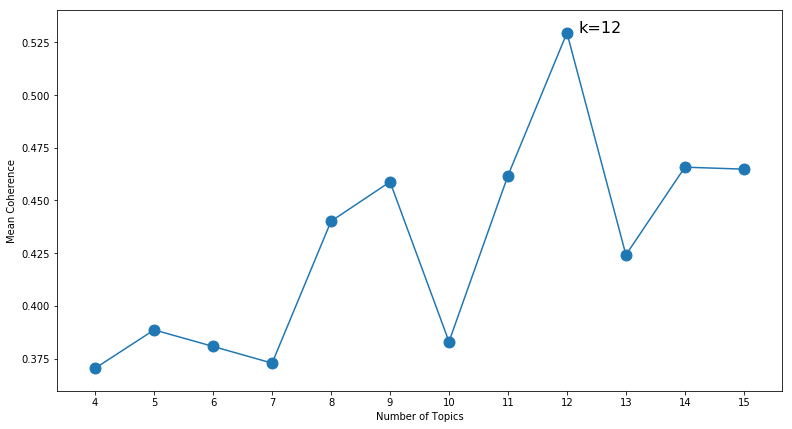

In [81]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [82]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: league, season, leicester, premier, goal, ball, liverpool, game, united, players, team, arsenal, city, chelsea, manchester, club, football, everton, palace, manager
Topic 02: trump, eu, people, uk, brexit, time, health, government, clinton, bank, campaign, women, vote, world, britain, party, get, work, way, think
Topic 03: bank, rbs, deutsche, banks, shares, lloyds, barclays, banking, libor, taxpayer, investors, stake, bailout, doj, cryan, capital, ppi, natwest, monte, italian
Topic 04: superman, batman, prize, promoter, parker, gibson, entries, marvel, barclays, tickets, mel, superhero, winners, competition, movie, trek, film, details, warner, entry
Topic 05: album, film, music, songs, pop, song, band, rock, love, festival, bowie, sound, review, films, star, singer, guitar, movie, track, debut
Topic 06: detective, sequences, immersive, orchestral, spins, acclaim, compile, premiered, inventive, revenant, theo, grossed, dutchman, artwork, fer, rhythms, meryl, sonic, vinyl, bfi

In [83]:
#UCI
from math import log
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            texts_2w = 0
            texts_1stw = 0
            texts_2ndw = 0
            #pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            for topic_ind2 in range(len(term_rankings)):
                if pair[0] in term_rankings[topic_ind2] and pair[1] in term_rankings[topic_ind2]:
                    texts_2w += 1
                if pair[0] in term_rankings[topic_ind2]:
                    texts_1stw += 1
                if pair[1] in term_rankings[topic_ind2]:
                    texts_2ndw += 1
            pair_prob = log((10**-12 + texts_2w / len(term_rankings)) / ((texts_1stw / len(term_rankings))*texts_1stw / len(term_rankings)))
            pair_scores.append(pair_prob)
        # get the sum for all pairs in this topic
        topic_score = sum(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    #print(term_rankings)
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=245.0275
K=05: Coherence=285.2760
K=06: Coherence=330.4992
K=07: Coherence=336.6499
K=08: Coherence=352.9326
K=09: Coherence=281.6575
K=10: Coherence=367.4595
K=11: Coherence=351.2774
K=12: Coherence=298.1164
K=13: Coherence=396.3637
K=14: Coherence=436.4271
K=15: Coherence=384.8492


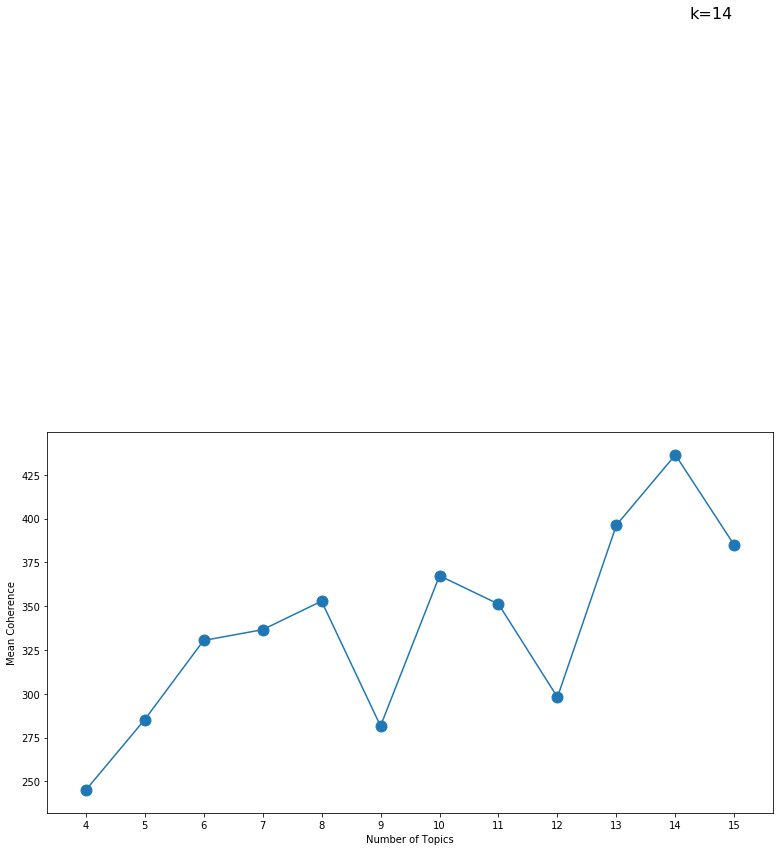

In [84]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [85]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: league, season, leicester, premier, goal, liverpool, game, ball, players, united, team, city, arsenal, football, chelsea, manchester, club, everton, palace, half
Topic 02: trump, eu, people, uk, bank, brexit, government, health, clinton, campaign, vote, britain, party, women, time, leave, referendum, nhs, banks, european
Topic 03: zika, virus, infected, transmission, aerial, tropical, vaccines, dimension, carlos, centers, miami, borne, derek, infections, syndrome, organic, brazil, infectious, rio, aforementioned
Topic 04: cheryl, academy, idris, vickers, elba, sciences, dylan, butler, nominees, kenneth, nobel, arts, gerard, tina, favourites, loads, evolving, wendy, inclusion, implemented
Topic 05: album, music, band, pop, songs, song, rock, love, life, review, film, sound, time, show, singer, internet, video, bowie, something, live
Topic 06: lallana, sturridge, firmino, coutinho, guidolin, moreno, mignolet, francesco, henderson, stirring, unmarked, drake, klopp, alberto, live

In [86]:
#Umass

from math import log
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            texts_2w = 0 #two words probability
            texts_1stw = 0 #probability of the first word in a pair
            #pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
            for topic_ind2 in range(len(term_rankings)):
                if pair[0] in term_rankings[topic_ind2] and pair[1] in term_rankings[topic_ind2]:
                    texts_2w += 1
                if pair[0] in term_rankings[topic_ind2]:
                    texts_1stw += 1
            pair_prob = log((10**-12 + texts_2w / len(term_rankings)) / (texts_1stw / len(term_rankings)))
            pair_scores.append(pair_prob)
        # get the sum for all pairs in this topic
        topic_score = sum(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    #print(term_rankings)
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=-9.1842
K=05: Coherence=-10.2586
K=06: Coherence=-4.9676
K=07: Coherence=-14.4571
K=08: Coherence=-20.3009
K=09: Coherence=-19.4827
K=10: Coherence=-17.3348
K=11: Coherence=-35.0428
K=12: Coherence=-11.4160
K=13: Coherence=-17.2206
K=14: Coherence=-24.4808
K=15: Coherence=-21.9422


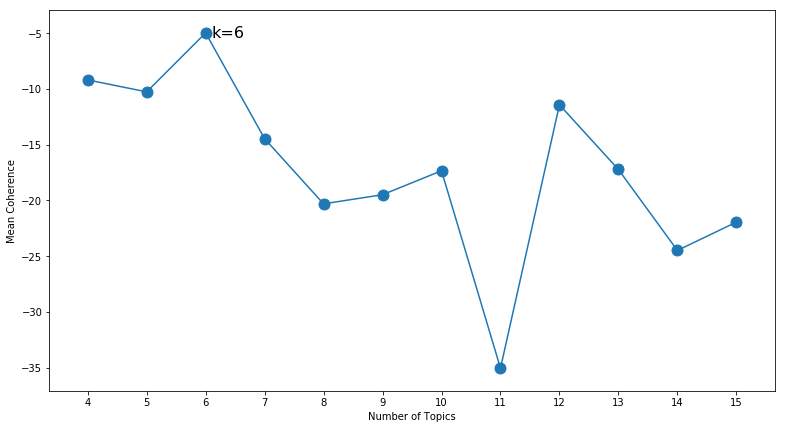

In [87]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [88]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: league, season, leicester, premier, goal, liverpool, game, ball, united, players, team, city, football, arsenal, chelsea, club, manchester, half, manager, everton
Topic 02: trump, eu, people, uk, bank, brexit, health, government, clinton, campaign, vote, britain, party, referendum, leave, nhs, banks, women, european, financial
Topic 03: promoter, prize, entries, tickets, barclays, winners, n1, teamed, competition, kings, details, reserves, liability, cryan, entry, failings, promotion, entered, stamped, passion
Topic 04: fisher, carrie, princess, awakens, wars, trailer, disclosed, star, shades, daunting, disney, force, wishes, views, delaney, christie, rogue, surrender, grey, 8m
Topic 05: film, album, music, band, pop, songs, song, movie, life, love, time, star, films, people, best, rock, review, something, show, story
Topic 06: shaun, sheep, wallace, upward, arc, keyboards, gibson, tuition, cork, standalone, ambient, rumour, sequel, mars, showcase, valentine, sexy, aesthetic,

In [ ]:
#LDA & UCI chosen
class NewsRecommender:
    """
    обучить систему на корпусе текстов  с помощью тематической модели и метрики, выбранных в результате исследования
    """
    def train(self, texts):
        pass
    """
    выдать k самых пожих новостей для заданного заголовка по функции расстояния, выбранной в результате исследования
    обратите внимание, что text_sample может содержать слова не из обучающего корпуса
    """
    def recommend(self, text_sample, k):
        return ["news_1", "news_2", ... , "news_k"]